In [6]:
# import torch
# import torchvision
# import torchvision.datasets as datasets
# from torch.utils.data import DataLoader, Dataset, TensorDataset
# import torchvision.transforms as transforms

import pandas as pd
from pathlib import Path
from glob import glob
import torch
import torch.nn.functional as F
from torch import nn, optim
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models
import matplotlib.pyplot as plt
# import albumentations as A
# from albumentations.pytorch import ToTensor
import numpy as np
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
import matplotlib.pyplot as plt
import os

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import shutil
from skimage import io, transform


from collections import namedtuple
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time

import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler


Augmentation

In [7]:
t = transforms.Compose([
                       transforms.ToTensor()]
                      #  transforms.Normalize(mean=(0), std=(1))]
                       )

In [8]:
tr_data = datasets.MNIST(root='./data', train=True, download=True, transform=t)
# te_data = datasets.MNIST(root='./data', train=True, download=True, transform=t)

In [9]:
# bs = 64
# train_loader = DataLoader( tr_data, 
#                 batch_size=bs, drop_last=True, shuffle=True)

In [10]:
# train_data = datasets.ImageFolder(root = dir_train, transform = transforms.ToTensor())
# Finding out the mean and std so that I can normalize the Image
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in tr_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(tr_data)
stds /= len(tr_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.1307, 0.1307, 0.1307])
Calculated stds: tensor([0.3015, 0.3015, 0.3015])


In [11]:
IMG_SIZE = 64

train_transforms = transforms.Compose([
                          #  transforms.ToPILImage(),
                           transforms.Resize(IMG_SIZE),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(IMG_SIZE, padding = 10),
                           transforms.ToTensor(),
                          transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

val_transforms = transforms.Compose([
                           transforms.Resize(IMG_SIZE),
                           transforms.CenterCrop(IMG_SIZE),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])


test_transforms = transforms.Compose([
                          #  transforms.ToPILImage(),
                           transforms.Resize(IMG_SIZE),
                           transforms.ToTensor(),
                          transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),                     
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

In [12]:
tr_data = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
te_data = datasets.MNIST(root='./data', train=False, download=True, transform=test_transforms)

In [13]:
# next(iter(te_data))

In [14]:
# spitting the train data into two train and val (80:20 ratio)
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(tr_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [15]:
BATCH_SIZE = 64
train_loader = data.DataLoader(tr_data, 
                                 batch_size = BATCH_SIZE, 
                                 sampler=train_sampler)

valid_loader = data.DataLoader(tr_data, 
                                 batch_size = BATCH_SIZE,
                                 sampler=valid_sampler)

test_loader = data.DataLoader(te_data, 
                                batch_size = BATCH_SIZE)

In [16]:
print(f"datapoints:\ntrain loader: {len(train_loader)}\nval loader: {len(valid_loader)}\ntest loader: {len(test_loader)}")

datapoints:
train loader: 750
val loader: 188
test loader: 157


In [17]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [18]:
def plot_images(images, labels, classes, normalize = True):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        label = classes[int(labels[i])]
        ax.set_title(label)
        ax.axis('off')

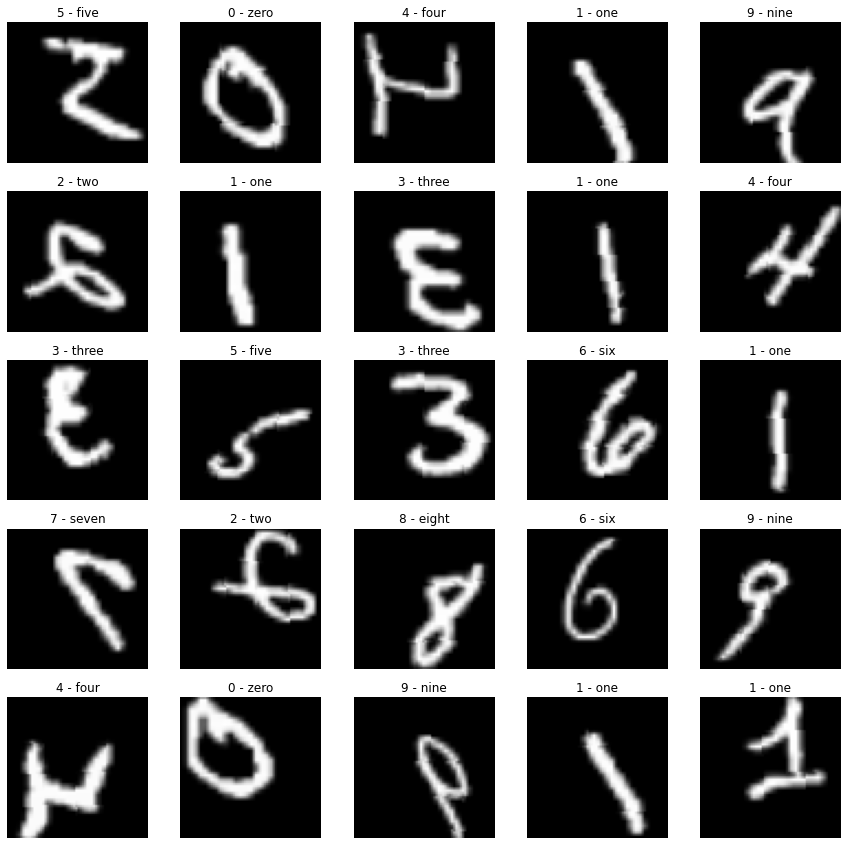

In [19]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [tr_data[i] for i in range(N_IMAGES)]])
# classes = train_data.classes
classes = tr_data.classes

plot_images(images, labels, classes)

In [20]:
!pip install pretrainedmodels

In [21]:
import pretrainedmodels
model = pretrainedmodels.resnet34(num_classes=1000, pretrained='imagenet')

In [22]:
!pip install torch-summary


In [23]:
from torchsummary import summary

In [24]:
summary(model, (3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Sequential: 1-5                        [-1, 64, 16, 16]          --
|    └─BasicBlock: 2-1                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-3                    [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-6                    [-1, 64, 16, 16]          --
|    └─BasicBlock: 2-2                   [-1, 64, 16, 16]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Sequential: 1-5                        [-1, 64, 16, 16]          --
|    └─BasicBlock: 2-1                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-3                    [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-6                    [-1, 64, 16, 16]          --
|    └─BasicBlock: 2-2                   [-1, 64, 16, 16]          --
|

In [25]:
model.last_linear.in_features

512

In [26]:
# fine tuning
dim_feats = model.last_linear.in_features # =512
nb_classes = 2
model.last_linear = nn.Linear(dim_feats, nb_classes)

In [27]:
summary(model, (3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Sequential: 1-5                        [-1, 64, 16, 16]          --
|    └─BasicBlock: 2-1                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-3                    [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-6                    [-1, 64, 16, 16]          --
|    └─BasicBlock: 2-2                   [-1, 64, 16, 16]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Sequential: 1-5                        [-1, 64, 16, 16]          --
|    └─BasicBlock: 2-1                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-3                    [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 16, 16]          128
|    |    └─ReLU: 3-6                    [-1, 64, 16, 16]          --
|    └─BasicBlock: 2-2                   [-1, 64, 16, 16]          --
|

In [28]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [29]:
device

device(type='cuda')

In [30]:
# next(iter(model.last_linear.parameters()))

In [31]:
FOUND_LR = 1e-3

# params = [
#           {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
#           {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
#           {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
#           {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
#           {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
#           {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
#           {'params': model.fc.parameters()}
#          ]

params = [
          {
              'params': model.last_linear.parameters()
          }
]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [32]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [33]:
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        # y_pred.eq(y.view(1, -1))
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        # correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        # acc_k = correct_k / batch_size
    return acc_1#, acc_k

In [34]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    # epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        y = y%2 # if odd then 1 , if even 0 (binary class)
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        # print(len(model(x)))
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y.long())
        acc_1 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        # epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    # epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1#, epoch_acc_5

In [38]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:
            y = y%2 # if odd then 1 , if even 0 (binary class)

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y.long())

            acc_1 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            # epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    # epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1#, epoch_acc_5

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1 = train(model, train_loader, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1 = evaluate(model, valid_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}%')
    # | ' \
          # f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}%')
    # | ' \
          # f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 2m 15s
	Train Loss: 0.425 | Train Acc @1:  80.95%
	Valid Loss: 0.396 | Valid Acc @1:  82.69%
Epoch: 02 | Epoch Time: 2m 15s
	Train Loss: 0.406 | Train Acc @1:  81.91%
	Valid Loss: 0.387 | Valid Acc @1:  83.11%
Epoch: 03 | Epoch Time: 2m 16s
	Train Loss: 0.403 | Train Acc @1:  82.23%
	Valid Loss: 0.380 | Valid Acc @1:  82.97%
Epoch: 04 | Epoch Time: 2m 15s
	Train Loss: 0.394 | Train Acc @1:  82.74%
	Valid Loss: 0.395 | Valid Acc @1:  82.98%
Epoch: 05 | Epoch Time: 2m 14s
	Train Loss: 0.389 | Train Acc @1:  83.01%
	Valid Loss: 0.385 | Valid Acc @1:  83.54%
Epoch: 06 | Epoch Time: 2m 14s
	Train Loss: 0.386 | Train Acc @1:  82.85%
	Valid Loss: 0.372 | Valid Acc @1:  83.84%
Epoch: 07 | Epoch Time: 2m 14s
	Train Loss: 0.387 | Train Acc @1:  83.07%
	Valid Loss: 0.373 | Valid Acc @1:  83.67%
Epoch: 08 | Epoch Time: 2m 14s
	Train Loss: 0.381 | Train Acc @1:  83.46%
	Valid Loss: 0.366 | Valid Acc @1:  84.25%
Epoch: 09 | Epoch Time: 2m 14s
	Train Loss: 0.380 | Train Acc @1

ValueError: ignored

In [1]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [2]:
images, labels, probs = get_predictions(model, valid_loader)

NameError: ignored

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (20, 20));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

### Misclassified Examples

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[int(true_label.cpu().numpy())]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[int(true_label.cpu().numpy())]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

In [ ]:
N_IMAGES = 50

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

## Predictions on Test Data

In [ ]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
        
    outputs = torch.cat(outputs, dim = 0)

    return outputs

In [ ]:
outputs = get_representations(model, test_loader)

In [ ]:
pred_test = [int(pr.numpy()) for pr in outputs.argmax(1)] # 0 for even, 1 for odd

I have lost my session and running again will take atleast 15 minute so skipping to run.